# User-Based Recommender System - Cosine Similarities

Iteration 5: evaluating the recommender system

### Read data

In [1]:
import pandas as pd
import numpy as np
movies = pd.read_csv("https://github.com/tiagofassoni/useful-datasets/raw/main/ml-latest-small/movies.csv")
ratings = pd.read_csv("https://github.com/tiagofassoni/useful-datasets/raw/main/ml-latest-small/ratings.csv")

### Create the `movie_user` table

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

# 1
data = ratings.merge(movies, on="movieId", how="left")

# 2
movie_user = data.pivot_table(index='userId',columns='title',values='rating')
movie_user.fillna(0, inplace=True)

### Train - Test split

#### 1st step: Let's find out all the ratings positions in this dataset different than 0

This will help us create the train and the test set (the `0` ratings cannot go to the test set, this is why we have to identify the non-zero ratings).

We will replace two random movies that user `80` has rated by zero. We will then predict the scores with our recommender:

In [3]:
ratings_pos = pd.DataFrame(
    np.nonzero(np.array(movie_user)) # find out all the positions different than 0
).T
ratings_pos.head()

,0,1
0,0,48
1,0,66
2,0,202
3,0,245
4,0,325


How to interpret the `rating_pos` dataframe? The values at the position `[0, 48]`, `[0, 66]`, `[0, 202]`, `[0, 245]`... are not zero. Those values in particular correspond to the first row (`user_id = 1`) of the dataframe, and to certain movies that this user has rated:

In [4]:
movie_user.iloc[0:2, [48, 66, 202, 245]]

title,"13th Warrior, The (1999)",20 Dates (1998),"Abyss, The (1989)","Adventures of Robin Hood, The (1938)"
userId,,,,
1,4.0,4.0,4.0,5.0
2,0.0,0.0,0.0,0.0


In total, we have `100832` non-zero values in the matrix. Those will be the "candidates" to become part of the test set.

In [5]:
len(ratings_pos)

100832

#### 2nd step: Create the train and test

In [7]:
# split with train and test
from sklearn.model_selection import train_test_split
train_pos, test_pos = train_test_split(ratings_pos, 
                                       random_state=123, 
                                       test_size=.1)

These values will go to the train set:

In [8]:
train_pos.sort_values([0,1]).head(3)

,0,1
0,0,48
1,0,66
3,0,245


...and these to the test set:

In [9]:
test_pos.sort_values([0,1]).head(1)

,0,1
2,0,202


Now we have two dataframes called `train_pos` and `test_pos` which contain the rating positions in the food dataframe. The next step will be to create a train and a test with the information in those positions: 

In [10]:
# create an empty dataframe full of 0, with the same shape as the movie_user data
train = np.zeros(movie_user.shape)

# fill the set with the food ratings based on the train positions
for pos in train_pos.values: 
    index = pos[0]
    col = pos[1]
    train[index, col] = movie_user.iloc[index, col]

train = pd.DataFrame(train, 
                     columns=movie_user.columns, 
                     index=movie_user.index)

From the movies we had looked at that user 1 had rated, 3 of them fell into the train set:

In [11]:
train.iloc[0:2, [48, 66, 202, 245]]

title,"13th Warrior, The (1999)",20 Dates (1998),"Abyss, The (1989)","Adventures of Robin Hood, The (1938)"
userId,,,,
1,4.0,4.0,0.0,5.0
2,0.0,0.0,0.0,0.0


In [12]:
# now it is time for the test set. We will follow the same process
test = np.zeros(movie_user.shape)

for pos in test_pos.values: 
    index = pos[0]
    col = pos[1]
    test[index, col] = movie_user.iloc[index, col]
    
test = pd.DataFrame(test, 
                    columns=movie_user.columns, 
                    index=movie_user.index)

The last of the movies we had looked at for user 1 (The Abyss) fell into the test set:

In [13]:
test.iloc[0:2, [48, 66, 202, 245]]

title,"13th Warrior, The (1999)",20 Dates (1998),"Abyss, The (1989)","Adventures of Robin Hood, The (1938)"
userId,,,,
1,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0


In [14]:
true_test_ratings = []

for row in test_pos.iterrows():
    true_test_ratings.append(movie_user.iloc[int(row[1][0]), int(row[1][1])])

In [15]:
test_pos = test_pos.assign(true_rating = true_test_ratings)

In [16]:
test_pos.head()

,0,1,true_rating
22404,151,7502,4.5
51868,335,5677,5.0
50519,325,3485,3.0
45912,303,8234,4.0
71995,461,9671,4.0


#### 3rd step: build the similarity matrix for the train set

In [17]:
# train the model
train_similarity = pd.DataFrame(cosine_similarity(train), 
                                columns=train.index, 
                                index=train.index)
train_similarity.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.01485,0.063542,0.175605,0.106767,0.101605,0.145946,0.098403,0.037826,0.009547,...,0.046948,0.117939,0.192136,0.053769,0.151404,0.144266,0.258045,0.269408,0.088118,0.129491
2,0.014850,1.00000,0.000000,0.004105,0.018283,0.027504,0.023130,0.029534,0.000000,0.052741,...,0.166003,0.018536,0.006012,0.000000,0.000000,0.025582,0.014257,0.042148,0.030650,0.094009
3,0.063542,0.00000,1.000000,0.002502,0.005572,0.004311,0.000000,0.005401,0.000000,0.000000,...,0.002486,0.005423,0.025653,0.000000,0.011981,0.007045,0.021378,0.022469,0.000000,0.027249


#### 4th step: Predict rating for a single movie of the test set

We will look at the movie "The Abyss" and user 1 - the data value in position `[0, 202]`

We use only the ratings on the train set, and the similarity matrix computed only from the train set:

In [18]:
results = (
    pd.DataFrame({
        'ratings': train.loc[:,"Abyss, The (1989)"], 
        'similarities' : train_similarity.loc[1,:].tolist()
    }))
results.head()

,ratings,similarities
userId,,
1,0.0,1.000000
2,0.0,0.014850
3,0.0,0.063542
4,0.0,0.175605
5,0.0,0.106767


As always, we compute the weights from the similarities:

In [19]:
results = results.assign(weights = results.similarities / (sum(results.similarities)-1))

In [20]:
results.head(3)

,ratings,similarities,weights
userId,,,
1,0.0,1.000000,0.014077
2,0.0,0.014850,0.000209
3,0.0,0.063542,0.000894


Then we weight the rating that each user gave to that movie with each user's weight:

In [21]:
results = results.assign(weighted_ratings = results.ratings * results.weights)
results.head(3)

,ratings,similarities,weights,weighted_ratings
userId,,,,
1,0.0,1.000000,0.014077,0.0
2,0.0,0.014850,0.000209,0.0
3,0.0,0.063542,0.000894,0.0


And get the predicted rating for user 1 for "The Abyss" by adding up all the weighted ratings:

In [22]:
pred_rating = results.weighted_ratings.sum()
pred_rating

0.535605956675155

Real rating for user 1 for "The Abyss":

In [23]:
true_rating = movie_user.loc[1, "Abyss, The (1989)"]
true_rating

4.0

We can compute the error as the true rating minus the predicted rating:

In [24]:
error = true_rating - pred_rating
error

3.464394043324845

Now we just need to do that for all of the movies in the test set!

## Computing all recommendations for the test set

We will build a function that computes the ratings for a single user and a single movie

In [25]:
def recommender(index_pos, column_pos, sim_df, data): 
    # build a df with the ratings for one movie (column_name) and
    # the similarities to one user (index_name)
    results = (
    pd.DataFrame({
        'ratings': data.iloc[:,column_pos], 
        'similarities' : sim_df.iloc[index_pos,:].tolist()
    }))
    
    # compute the weights
    results = results.assign(weights = results.similarities / (sum(results.similarities) -1))
    
    # compute the weighted ratings
    results = results.assign(weighted_ratings = results.ratings * results.weights)
    
    # return rating prediction for one user and one movie
    return results.weighted_ratings.sum()

In [26]:
recommender(0, 202, train_similarity, train)

0.535605956675155

In [27]:
test_pos

,0,1,true_rating
22404,151,7502,4.5
51868,335,5677,5.0
50519,325,3485,3.0
45912,303,8234,4.0
71995,461,9671,4.0
...,...,...,...
66801,431,115,4.0
32466,220,6602,3.5
48374,312,3643,4.0
6736,44,6582,4.0


Let's store the recommendations on a list:

In [28]:
recs_test = []

for row in test_pos.iterrows():
    recs_test.append(
        recommender(
            index_pos = int(row[1][0]), 
            column_pos = int(row[1][1]), 
            sim_df = train_similarity, 
            data = train
        )
    )

And we assign the list as a column of the `test_pos` dataframe:

In [29]:
test_pos = test_pos.assign(pred_rating = recs_test)

In [30]:
test_pos.head()

,0,1,true_rating,pred_rating
22404,151,7502,4.5,0.052810
51868,335,5677,5.0,0.815696
50519,325,3485,3.0,0.239934
45912,303,8234,4.0,0.283489
71995,461,9671,4.0,0.027441


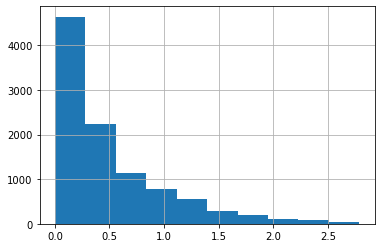

In [31]:
test_pos.pred_rating.hist();

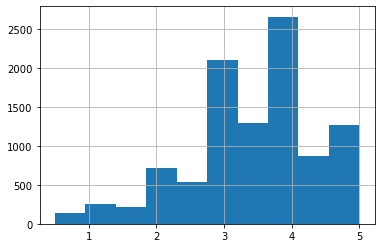

In [32]:
test_pos.true_rating.hist();

## Performance metrics

In [33]:
from sklearn.metrics import mean_absolute_error, r2_score

In [34]:
mean_absolute_error(test_pos.true_rating, test_pos.pred_rating)

3.0035691396551902

In [35]:
r2_score(test_pos.true_rating, test_pos.pred_rating)

-8.388145371440423

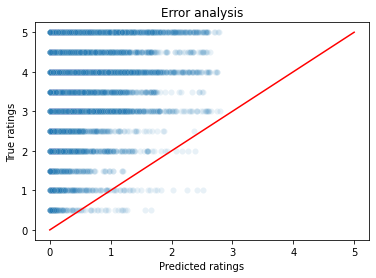

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions = test_pos.pred_rating
true_values = test_pos.true_rating

plt.title('Error analysis')
plt.xlabel('Predicted ratings')
plt.ylabel('True ratings')
sns.lineplot(x=[0,5], y=[0,5], color='red')
sns.scatterplot(x=predictions, y=true_values, alpha=0.1)
plt.show()

## Final step: DEAL WITH THE ZEROS!

And try to improve the performance.